# testing models from CMIP6 historical runs
This script opens up CMIP6 historical model run files with data on precipitation pr and surface temperature tas and calculates monthly anomalies for each region.  Then tests the models for each region.  


In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302


In [5]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [6]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/tas/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tas/gr1.5/v20190919/*.nc
Model MPI-ESM1-2-HR has different time so is now removed
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/tas/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/tas/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190818/*.nc
BCC-ESM1 

In [7]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/pr/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/pr/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/pr/gr1.5/v20190919/*.nc
MPI-ESM1-2-HR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/pr/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p

In [8]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [9]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [10]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [11]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## select out time around krakatoa eruption
I need to select out the time around each eruption or at least store each eruption in a separate array so that I don't get a "minimum" for one eruption in 1891 and the next in 1991

In [12]:
# select out time around krakatoa eruption
models = models.sel(time = slice('1850-01','1900-01'))
models

,Array,Chunk
Bytes,2.98 GB,1.38 MB
Shape,"(43, 601, 120, 240)","(1, 12, 120, 240)"
Count,53312 Tasks,2193 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.95 GB,2.76 MB
Shape,"(43, 601, 120, 240)","(1, 12, 120, 240)"
Count,61564 Tasks,2193 Chunks
Type,float64,numpy.ndarray


In [13]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [20]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [21]:
models

,Array,Chunk
Bytes,2.98 GB,1.38 MB
Shape,"(43, 601, 120, 240)","(1, 12, 120, 240)"
Count,53312 Tasks,2193 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.95 GB,2.76 MB
Shape,"(43, 601, 120, 240)","(1, 12, 120, 240)"
Count,61564 Tasks,2193 Chunks
Type,float64,numpy.ndarray


## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [22]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [23]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

## Anomalies

In [24]:
# use functions to calculate the monthly anomalies for the globe
mon_anom_Glob = func.monthly_anomaly(models_w, '1850-01', '1881-01')

In [25]:
# select out regions for other anomalies 
mon_anom_SH = mon_anom_Glob.sel(lat=slice(-90,0)) 
mon_anom_NH = mon_anom_Glob.sel(lat=slice(0,90)) 
mon_anom_Aus = mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
mon_anom_EA = mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

### Add in multi-model mean to xarray

# Make the next 4 cells into a function

In [ ]:
# calculate the mmm
mmm_anom_Glob = mon_anom_Glob.mean(dim='model')
mmm_anom_SH = mon_anom_SH.mean(dim='model')
mmm_anom_Aus = mon_anom_Aus.mean(dim='model')
mmm_anom_EA = mon_anom_EA.mean(dim='model')

In [ ]:
# add model dimension to mmm array
ds = []
ds.append(mmm_anom_Glob)
mmm = xr.concat(ds, dim='models', coords = 'minimal')
mmm.coords['model'] = 'mmm'
mmm

In [ ]:
# append the mmm to the rest of the anomaly array
ds=[]
ds.append(mon_anom_Glob)
ds.append(mmm)
multi_model = xr.concat(ds, dim='model', coords = 'minimal')

In [26]:
# take the lat lon mean befreo taking the std 
mean_mon_Glob = mon_anom_Glob.mean(dim = ['lat','lon'])
mean_mon_SH = mon_anom_SH.mean(dim = ['lat','lon'])
mean_mon_Aus = mon_anom_Aus.mean(dim = ['lat','lon'])
mean_mon_EA = mon_anom_EA.mean(dim = ['lat','lon'])

In [27]:
# calculate the standard deviation for each model over the time period from 1850-1880
std_Glob = mean_mon_Glob.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_SH = mean_mon_SH.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_Aus = mean_mon_Aus.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_EA = mean_mon_EA.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])

In [28]:
# calculate the mean for each model over the time period from 1850-1880
time_mean_Glob = mean_mon_Glob.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_SH = mean_mon_SH.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_Aus = mean_mon_Aus.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_EA = mean_mon_EA.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])

In [89]:
# select out time around krakatoa eruption for graphs and counts, 
K_mean_mon_Glob = mean_mon_Glob.sel(time = slice('1883-08', '1888-08'))
K_mean_mon_SH = mean_mon_SH.sel(time = slice('1883-08', '1888-08'))
K_mean_mon_Aus = mean_mon_Aus.sel(time = slice('1883-08', '1888-08'))
K_mean_mon_EA = mean_mon_EA.sel(time = slice('1883-08', '1888-08'))

# Count below threshold for each model
First select only the values below our threshold, then get the count of unmasked values along the time dimension


In [35]:
# check if the anomalies are less than the 2 standard deviation 
model_2std_count_Glob = K_mean_mon_Glob.where(K_mean_mon_Glob < time_mean_Glob - 2*std_Glob).count('time')
model_2std_count_SH = K_mean_mon_SH.where(K_mean_mon_SH < time_mean_SH - 2*std_SH).count('time')
model_2std_count_Aus = K_mean_mon_Aus.where(K_mean_mon_Aus < time_mean_Aus - 2*std_Aus).count('time')
model_2std_count_EA = K_mean_mon_EA.where(K_mean_mon_EA < time_mean_EA - 2*std_EA).count('time')

In [101]:
print(std_Glob.sel(model='ACCESS-CM2').tas.values)
print(2*std_Glob.sel(model='ACCESS-CM2').tas.values)
print(3*std_Glob.sel(model='ACCESS-CM2').tas.values)

0.08453271573425182
0.16906543146850364
0.2535981472027555


In [103]:
print(-K_mean_mon_Glob.sel(model='ACCESS-CM2').tas.values)

[0.09599384 0.05855401 0.13202315 0.29220082 0.20390751 0.26447566
 0.35782736 0.32115377 0.27524294 0.30949964 0.26510576 0.24594876
 0.14775789 0.27631798 0.26908088 0.33246769 0.22641423 0.261413
 0.25779757 0.24908889 0.25220018 0.18626925 0.21695991 0.22548835
 0.07341332 0.24782401 0.27686286 0.28833139 0.27974231 0.25429238
 0.18794915 0.25935493 0.26486942 0.27245459 0.30583947 0.2302285
 0.17351551 0.20748891 0.17262977 0.26864959 0.1697298  0.27841775
 0.20750313 0.13323441 0.11611559 0.1354202  0.13184072 0.05898981
 0.06156353 0.10368787 0.07636761 0.14702876 0.13129238 0.12605627
 0.15192303 0.10357376 0.08111689 0.03147498 0.09683921 0.0717891
 0.0556476 ]


In [108]:
# tests how far outside the threshold 
# defines the threshold of 2 std and calculates how far outside the threhold the monthly anomalies are 
# K_mean_mon_Glob is the monthly anomalies (with mean in lat and lon taken)
out_thld = time_mean_Glob - 2*std_Glob - K_mean_mon_Glob
model_test_2std = xr.where(K_mean_mon_Glob < time_mean_Glob - 2*std_Glob, out_thld, 0)

In [109]:
# calculate  threhold for 3 standard deviations so I can include it in the plots 
thld_3std = -(time_mean_Glob - 3*std_Glob)
thld_2std = -(time_mean_Glob - 2*std_Glob)

[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.7s
[########################################] | 100

[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.2s
[########################################] | 100

[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.4s
[########################                ] | 62% Completed |  2.0s


ValueError: setting an array element with a sequence.

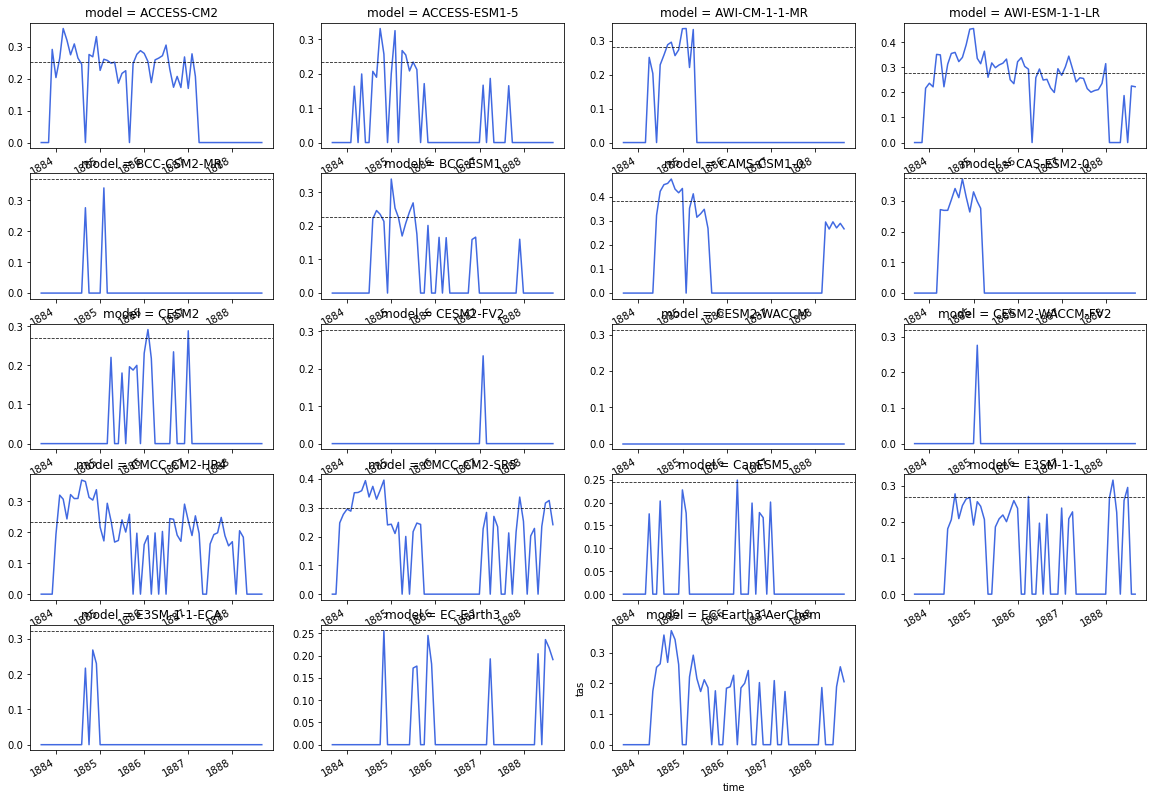

In [107]:
fig = plt.figure(figsize=(20,30))
axs = []

cols = 4
rows = 11

with dask.diagnostics.ProgressBar():
    for i, m in enumerate(model_test_2std.model):
        # Add a subplot with a projection
        ax = fig.add_subplot(rows, cols, i+1)

        # Select this model's data and plot it
        model_test_2std.sel(model=m).tas.plot(ax=ax, color='royalblue')
        # plot a horizontal line indicating 3 standard deviations
        #thld_3std.sel(model=m).tas.plot(ax=ax, color='k', '--')
        ax.axhline(y=thld_3std.sel(model=m).tas, color = 'k', linestyle = '--', alpha = 0.9, linewidth='0.8')
        
        # remove x and y axes
        ax.set_xlabel(None)
        ax.set_ylabel(None)

#plt.savefig('statsig_graph_tas.png', dpi=300, bbox_inches='tight')

In [95]:
print(time_mean_Glob.sel(model='ACCESS-CM2').tas.values)
print(thld_3std.sel(model='ACCESS-CM2').tas.values)

-2.172822541491593e-17
0.2535981472027555


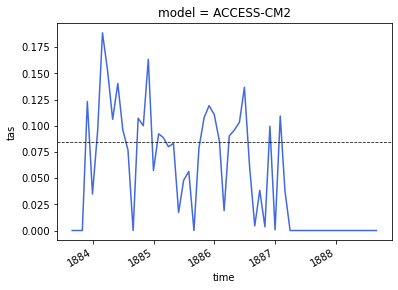

In [112]:
fig, axes = plt.subplots(1,1)
model_test_2std.sel(model='ACCESS-CM2').tas.plot(ax=axes, color='royalblue')
axes.axhline(y=std_Glob.sel(model='ACCESS-CM2').tas, color = 'k', linestyle = '--', alpha = 0.9, linewidth='0.8')
# this is not a good graph, 
# 0 on yaxis is 2std and then dotted line is 3std, so it's how far the anomalies are from 2std
# rather than showing the actual anomalies

(0.16906543146850367, 0.37414497834949556)

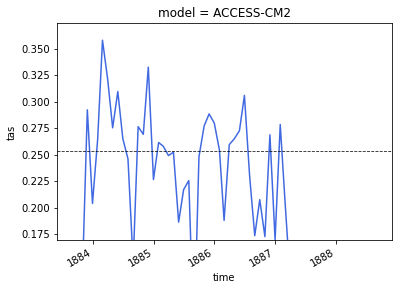

In [116]:
# this graph is better because it shows the actual anomalies and still cuts off values below 2std
fig, axes = plt.subplots(1,1)
(-K_mean_mon_Glob).sel(model='ACCESS-CM2').tas.plot(ax=axes, color='royalblue')
axes.axhline(y=thld_2std.sel(model='ACCESS-CM2').tas, color = 'k', linestyle = '--', alpha = 0.9, linewidth='0.8')
axes.axhline(y=thld_3std.sel(model='ACCESS-CM2').tas, color = 'k', linestyle = '--', alpha = 0.9, linewidth='0.8')
axes.set_ylim(bottom=thld_2std.sel(model='ACCESS-CM2').tas, top=None)

(0.16906543146850367, 0.3757187271329161)

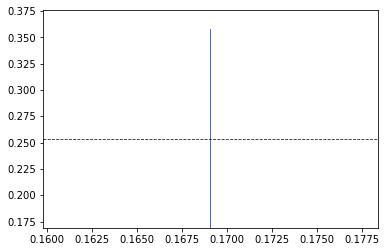

In [128]:
# trying to do fill_between here 
fig, axes = plt.subplots(1,1)
axes.fill_between(thld_2std.sel(model='ACCESS-CM2').tas, (-K_mean_mon_Glob).sel(model='ACCESS-CM2').tas, color='royalblue')
axes.axhline(y=thld_3std.sel(model='ACCESS-CM2').tas, color = 'k', linestyle = '--', alpha = 0.9, linewidth='0.8')
axes.set_ylim(bottom=thld_2std.sel(model='ACCESS-CM2').tas, top=None)

## could also use fill between if i kind of want the appearnce of a bar graph without actually making a bar graph
FILL between anomalies and 2std, then add in 3std dotted line 

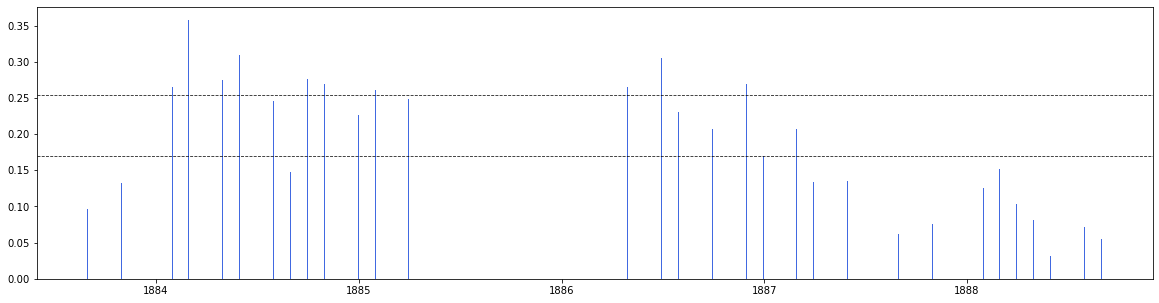

In [126]:
# here is a bar plot instead but i think it's no good cos there are not enough room to fit all the lines, so some get left out 
fig, axes = plt.subplots(1,1, figsize=(20,5))
data = -K_mean_mon_Glob.sel(model='ACCESS-CM2').tas
plt.bar(data.time, data, color='royalblue')
#plot 2 and 3 std line
axes.axhline(y=thld_2std.sel(model='ACCESS-CM2').tas, color = 'k', linestyle = '--', alpha = 0.9, linewidth='0.8')
axes.axhline(y=thld_3std.sel(model='ACCESS-CM2').tas, color = 'k', linestyle = '--', alpha = 0.9, linewidth='0.8')

[########################################] | 100% Completed |  5.3s
[###############################         ] | 79% Completed |  4.5s


KeyboardInterrupt: 

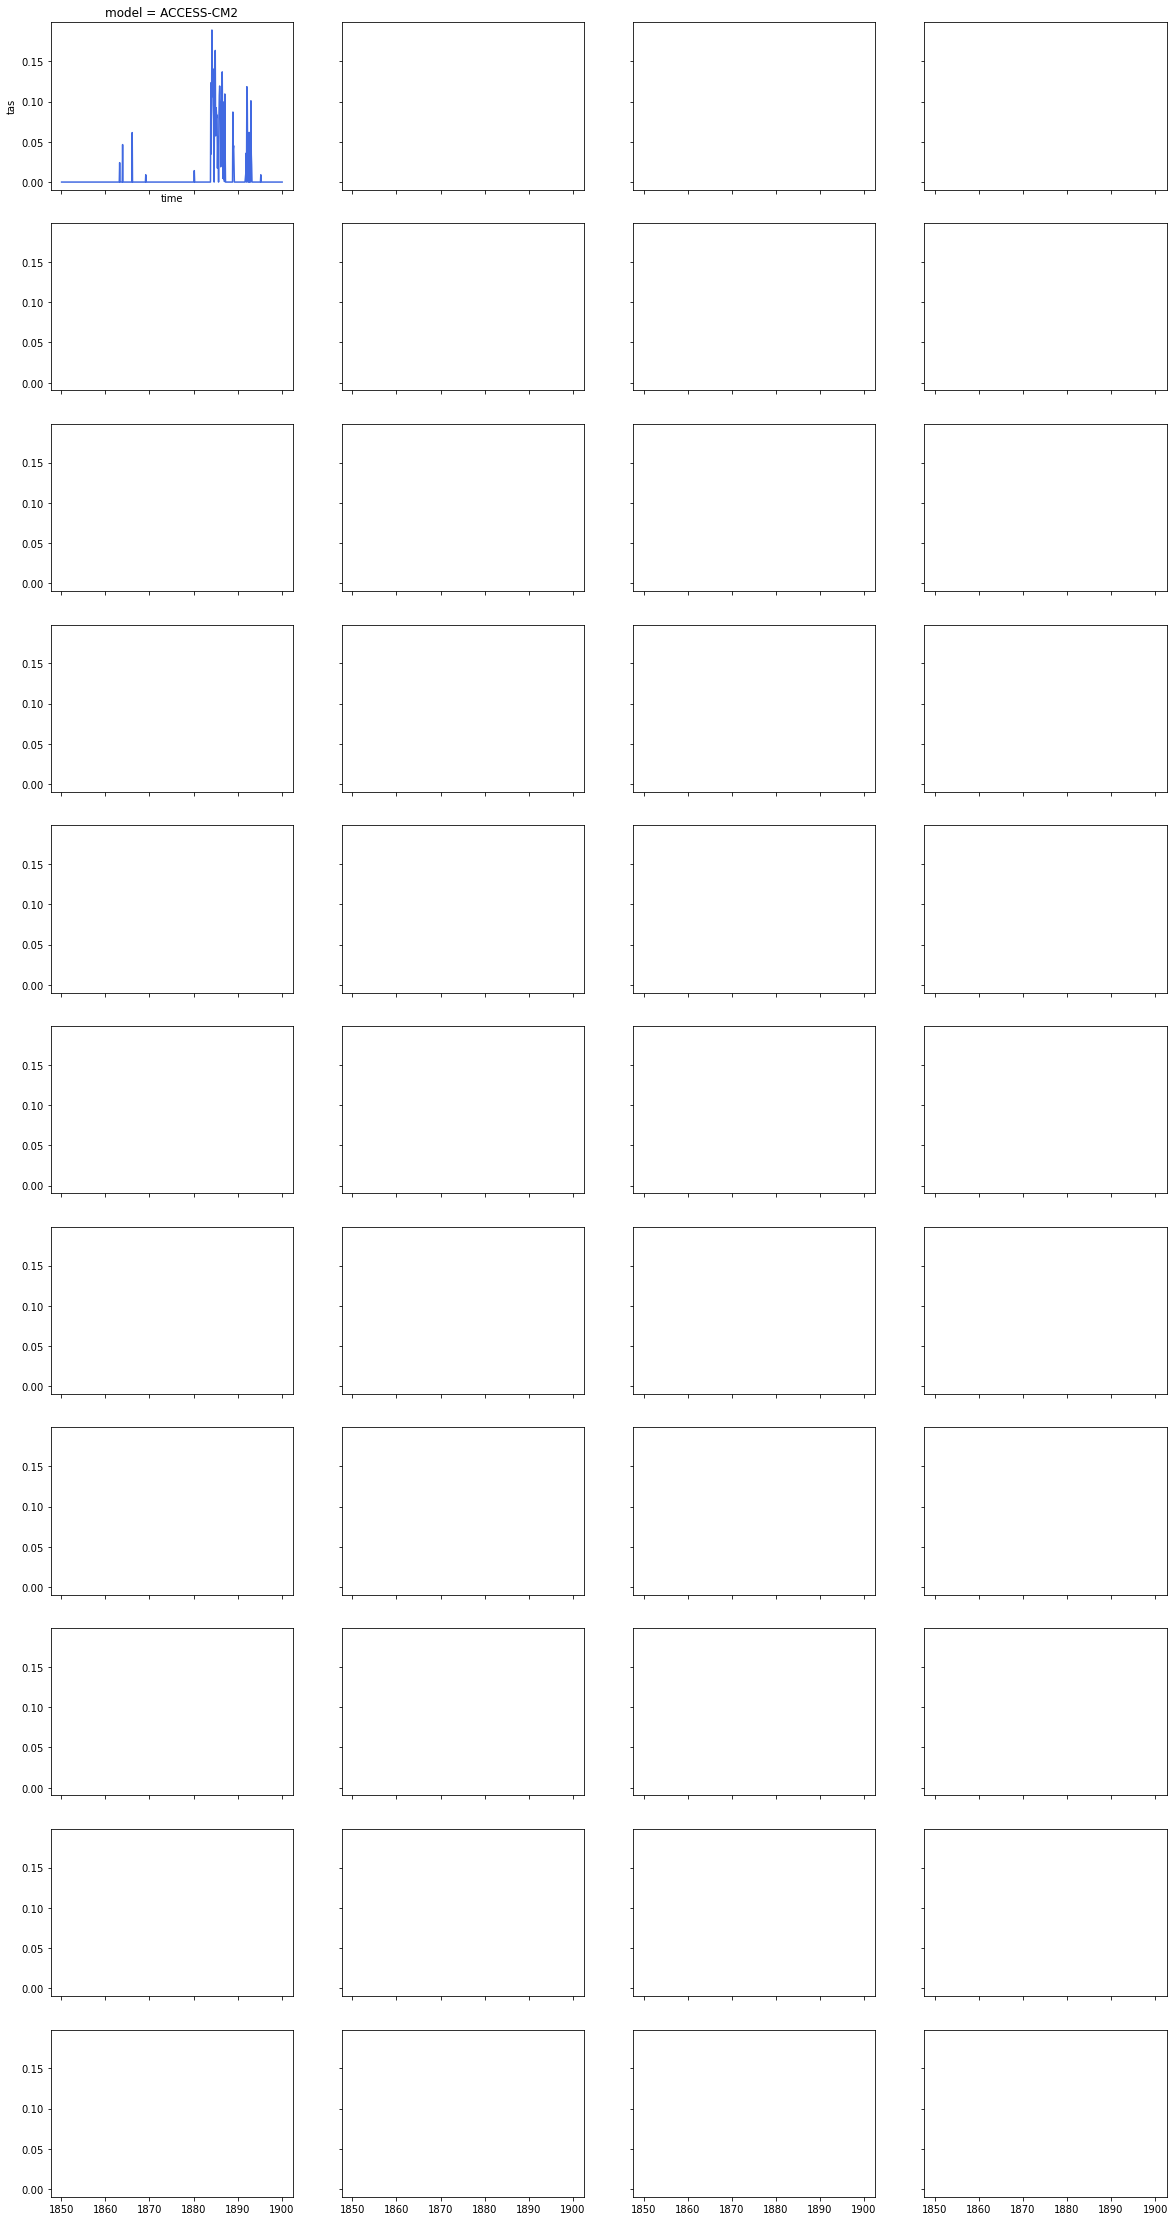

In [80]:
rows = 11
cols=4
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(20,40))

# make subplots for each region

for i, m in enumerate(model_test_2std.model):
    for r in range(rows):
        for c in range(cols):
            with dask.diagnostics.ProgressBar():
                model_test_2std.sel(model=m).tas.plot(ax = axes[r,c], color = 'royalblue')

            # plot a horizontal line indicating 3 standard deviations
            #thld_3std.sel(model=m).tas.plot(ax = axes[r,c], color = 'k', linestyle = '--')
            #ax.axhline(y=thld_3std.sel(model=m).tas, color = 'k', linestyle = '--', alpha = 0.9, linewidth='0.8')

            # remove x and y axes
            ax.set_xlabel(None)
            ax.set_ylabel(None)
                
#plt.savefig('statsig_graph_tas.png', dpi=300, bbox_inches='tight')

In [68]:
# check if the anomalies are less than the 3 standard deviation 
model_3std_count_Glob = mean_mon_Glob.where(mean_mon_Glob < time_mean_Glob - 3*std_Glob).count('time')
model_3std_count_SH = mean_mon_SH.where(mean_mon_SH < time_mean_SH - 3*std_SH).count('time')
model_3std_count_Aus = mean_mon_Aus.where(mean_mon_Aus < time_mean_Aus - 3*std_Aus).count('time')
model_3std_count_EA = mean_mon_EA.where(mean_mon_EA < time_mean_EA - 3*std_EA).count('time')

condition = mean_mon_Glob < time_mean_Glob - std_Glob

## Minimum values for each model
The same idea, this time using 'min' instead of 'count'

In [66]:
# calculate the minimum anomaly (ie the coolest temperature/driest month in the 5 years after krakatoa)
model_min_Glob = K_mean_mon_Glob.sel(time=slice('1883-08', '1888-08')).min('time')
model_min_SH = K_mean_mon_SH.sel(time=slice('1883-08', '1888-08')).min('time')
model_min_Aus = K_mean_mon_Aus.sel(time=slice('1883-08', '1888-08')).min('time')
model_min_EA = K_mean_mon_EA.sel(time=slice('1883-08', '1888-08')).min('time')

# model_min_Glob = K_mean_mon_Glob.min('time')
# model_min_SH = K_mean_mon_SH.min('time')
# model_min_Aus = K_mean_mon_Aus.min('time')
# model_min_EA = K_mean_mon_EA.min('time')

## Date of minimum value for each model¶
Start off by finding the index of the minimum value - argmin.

In [67]:
# find the date of the minimum anomaly
min_index_Glob = K_mean_mon_Glob.where(K_mean_mon_Glob == model_min_Glob).argmin('time')
min_index_SH = K_mean_mon_SH.where(K_mean_mon_SH == model_min_SH).argmin('time')
min_index_Aus = K_mean_mon_Aus.where(K_mean_mon_Aus == model_min_Aus).argmin('time')
min_index_EA = K_mean_mon_EA.where(K_mean_mon_EA == model_min_EA).argmin('time')

These indices can be converted to time values all at once by using min_index as an array index

There's a "ghost" time axis in the result which might cause problems, let's get rid of it. Our returned values aren't time dependent

In [29]:
# find the date the minimum value occured on the global scale
min_date_Glob_pr = K_mean_mon_Glob.pr.time[min_index_Glob.pr].drop('time').drop('month')
min_date_Glob_tas = K_mean_mon_Glob.tas.time[min_index_Glob.tas].drop('time').drop('month')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_a

In [ ]:
# find the date the minimum value occured on the SH scale
min_date_SH_pr = K_mean_mon_SH.pr.time[min_index_SH.pr].drop('time').drop('month')
min_date_SH_tas = K_mean_mon_SH.tas.time[min_index_SH.tas].drop('time').drop('month')

In [ ]:
# find the date the minimum value occured on the Aus scale
min_date_Aus_pr = K_mean_mon_Aus.pr.time[min_index_Aus.pr].drop('time').drop('month')
min_date_Aus_tas = K_mean_mon_Aus.tas.time[min_index_Aus.tas].drop('time').drop('month')

In [ ]:
# find the date the minimum value occured on the EA scale
min_date_EA_pr = K_mean_mon_EA.pr.time[min_index_EA.pr].drop('time').drop('month')
min_date_EA_tas = K_mean_mon_EA.tas.time[min_index_EA.tas].drop('time').drop('month')

It could be helpful to put all of the results into a single dataset

In [31]:
event_stats_pr_Glob = xr.Dataset({
    'Count 2*std': model_2std_count_Glob.pr,
    'Count 3*std': model_3std_count_Glob.pr,
    'Min': model_min_Glob.pr,
    'Min Date': min_date_Glob_pr,
})

event_stats_pr_Glob

<xarray.Dataset>
Dimensions:   (model: 40)
Coordinates:
  * model     (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
Data variables:
    count     (model) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    min       (model) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    min_date  (model) datetime64[ns] 1887-01-31 1887-02-28 ... 1885-06-30

In [32]:
event_stats_tas_Glob = xr.Dataset({
    'Count 2*std': model_2std_count_Glob.tas,
    'Count 3*std': model_3std_count_Glob.tas,
    'Min': model_min_Glob.tas,
    'Min Date': min_time2_Glob_tas,
})

## perhaps try and add in the multimodel mean here too so it's also included in hte table 
or actually add in the mmm earlier so that i do all the calculations for it 

In [33]:
event_stats_tas_Glob_df = event_stats_pr_Glob.to_dataframe()
event_stats_tas_Glob_df.round(decimals=2)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


,count,min,min_date
model,,,
ACCESS-CM2,30,-0.062154,1887-01-31
ACCESS-ESM1-5,23,-0.052239,1887-02-28
AWI-CM-1-1-MR,19,-0.059788,1892-04-30
AWI-ESM-1-1-LR,34,-0.055855,1884-10-31
BCC-CSM2-MR,18,-0.057399,1863-03-31
BCC-ESM1,24,-0.050033,1890-02-28
CAMS-CSM1-0,16,-0.065772,1890-02-28
CAS-ESM2-0,25,-0.060345,1893-03-31
CESM2,24,-0.056107,1868-09-30


In [34]:
event_stats_pr_Glob_df = event_stats_pr_Glob.to_dataframe()
event_stats_pr_Glob_df.round(decimals=2)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


,count,min,min_date
model,,,
ACCESS-CM2,30,-0.062154,1887-01-31
ACCESS-ESM1-5,23,-0.052239,1887-02-28
AWI-CM-1-1-MR,19,-0.059788,1892-04-30
AWI-ESM-1-1-LR,34,-0.055855,1884-10-31
BCC-CSM2-MR,18,-0.057399,1863-03-31
BCC-ESM1,24,-0.050033,1890-02-28
CAMS-CSM1-0,16,-0.065772,1890-02-28
CAS-ESM2-0,25,-0.060345,1893-03-31
CESM2,24,-0.056107,1868-09-30


## Climtas event detection
The climtas library has some functions for event detection - it will find runs where a condition is true for multiple times, then let you run a function to calculate statistics for each event

In [ ]:
K_mean_mon_Glob < K_time_mean_Glob - 2*std_Glob

In [ ]:
import climtas

events = climtas.event.find_events(mean_mon_Glob.pr < time_mean_Glob.pr - std_Glob.pr, min_duration=2)
events

In [ ]:
coords = climtas.event.event_coords(mean_mon_Glob.pr, events)

def stat_func(event_data):
    return {'min': event_data.min().values,
            'min_date': event_data.time[event_data.argmin()].values}
    
minimum = climtas.event.map_events(da, events, stat_func)

coords.join(minimum)

## .where function
There are two kinds of .where().  dataset.where() is used for masking on a dataarray, while the top level xr.where(condition, option1, option2) chooses between 2 values.  

## Model test 
Check to see which models have a cooling signal 

## Figures

In [ ]:
# eruption date
e_date = ['1883-08','1902-10', '1963-03', '1982-04', '1991-06']
e_pre5yrs = ['1878-08','1897-10', '1958-03', '1977-04', '1986-06']
e_pre3mon = ['1883-05','1902-7', '1962-12', '1982-01', '1991-03']
e_post5yrs = ['1888-08','1907-10', '1968-03', '1987-04', '1996-06']
e_post10yrs = ['1893-08','1912-10', '1973-03', '1992-04', '2001-06']